In [7]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

engine = create_engine('sqlite:///db.sqlite')
connection = engine.connect()

request = "SELECT * FROM LostItem"
lost_item_df = pd.read_sql(request, connection, index_col="date")

# Convert index to datetime and temperature to float
lost_item_df.index = pd.to_datetime(lost_item_df.index,utc=True)
# GROUP BY DAY AND COUNT
lost_item_df_by_day = lost_item_df.groupby(lost_item_df.index.date).count()
lost_item_df_by_day = lost_item_df_by_day[["id"]].rename(columns={"id": "nb_lost_item"})
lost_item_df_by_day.index = pd.to_datetime(lost_item_df_by_day.index)
df = lost_item_df_by_day.loc["01-01-2021" :]


In [8]:
df

,nb_lost_item
2021-01-02,2
2021-01-03,8
2021-01-04,6
2021-01-05,7
2021-01-06,3
...,...
2022-12-27,2
2022-12-28,4
2022-12-29,13
2022-12-30,10


# Un point sur la comparaison des modèles statistiques

Pour comparer les modèles statistiques on utilise la notion de vraisemblance (likelihood). Etant donné les valeurs observées de la séries temporelles. Est ce qu'il est vraisemblable qu'elle ait été générée par les paramètres du modèle ? (p,q,d)??

Il s'avère que plus on ajoute de paramètre, meilleur sera la vraisemblance mathématiquement, mais cela conduit à de l'overfitting. (avec plein de paramètres, tout est possible).

Pour éviter cela, on va pénaliser l'ajout de trop de paramètre. C'est exactement ce que fait Critère d'information d'Akaike aka l'AIC (le BIC aussi mais il pénalise differement)

# Modèle ARIMA

In [29]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# Il faut absolument que le dataset soit trié dans l'ordre

model = pm.auto_arima(df.nb_lost_item, 
                      start_p=1, # autoregressive parameter: nb de lag à prendre en compte
                      start_q=1, # Mving Average : nb de bruits blanc
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3,  # maximum p and q au dessus de 3 risque overfit (non significativité)
                      max_q=3,
                      m=1,  seasonal=False,             # frequency of series m=1 defaut: pas de saison
                      d=None,           # let model determine 'd' nombre de differentiations
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) # Soit on fait par étape (on test + 1, si ok +2 ...) soit avec une gridsearch (on test tout)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3733.385, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4216.615, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3991.222, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3732.349, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4214.616, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3733.396, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3735.382, Time=2.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3730.723, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3731.687, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3731.697, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3989.224, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3733.686, Time=0.46 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.324 seconds
                               SARIMAX Results                                
Dep. Vari

le modèle sélectionné est (p=1,d=0,q=1): pas de trend retenu

La partie interessante est la suivante: on regarde l'AIC pour comparer aux autres modèles.

On vérifie que la p_value de tous les paramètres est inférieures à 0.05 
-  l'intercept est la moyenne de notre série différenciée, elle est censée être nulle mais on peut souvent ne pas faire autrement)
-  sigma est la variance résiduelle, elle est censée être normalement distribuée.

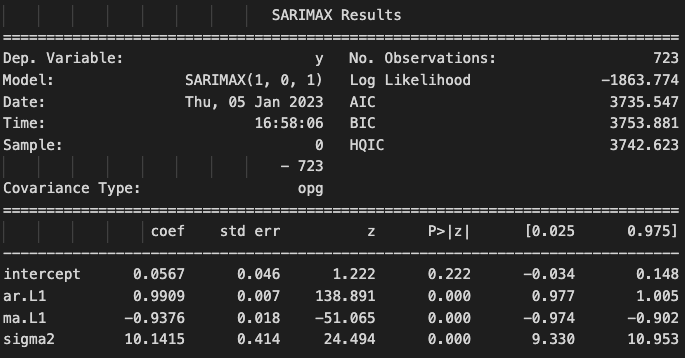

In [15]:
from IPython.display import Image
Image(filename='Results/ARIMA.png') 

# Modèle SARIMA

# saisonnalité mensuelle

In [1]:
model = pm.auto_arima(df.nb_lost_item, 
                      start_p=1, # autoregressive parameter: nb de lag à prendre en compte
                      start_q=1, # Mving Average : nb de bruits blanc
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3,  # maximum p and q au dessus de 3 risque overfit (non significativité)
                      max_q=3,
                      m=30,  seasonal=True,             # frequency of series m=1 defaut: pas de saison
                      D=1, # on force le modèle à considérer une saison
                      d=None,           # let model determine 'd' nombre de differentiations
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) # Soit on fait par étape (on test + 1, si ok +2 ...) soit avec une gridsearch (on test tout)

print(model.summary())

NameError: name 'pm' is not defined

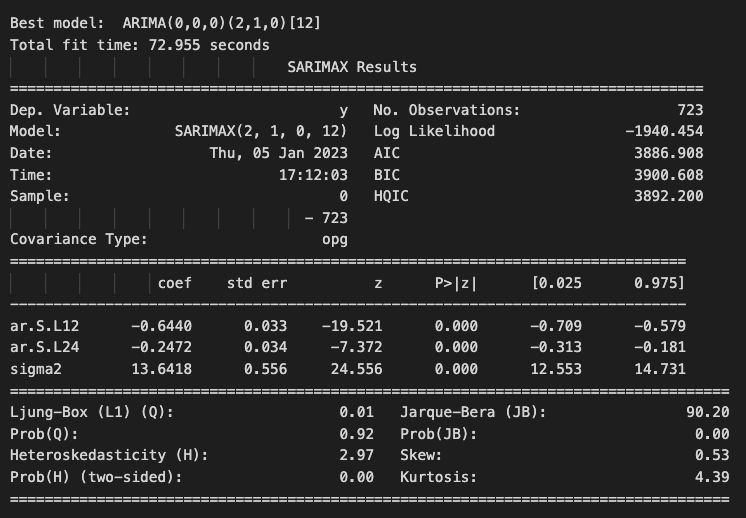

In [18]:
from IPython.display import Image
Image(filename='Results/SARIMA_12.png') 

L'AIC a augmenté

le meilleur modèle est ici un model avec de temps de latence.

## SARIMA hebdomadaire

In [25]:
smodel = pm.auto_arima(df.nb_lost_item, 
                      start_p=1, # autoregressive parameter: nb de lag à prendre en compte
                      start_q=1, # Mving Average : nb de bruits blanc
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3,  # maximum p and q au dessus de 3 risque overfit (non significativité)
                      max_q=3,
                      m=7,  seasonal=True,             # frequency of series m=1 defaut: pas de saison
                      D=1, # on force le modèle à considérer une saison
                      d=None,           # let model determine 'd' nombre de differentiations
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) # Soit on fait par étape (on test + 1, si ok +2 ...) soit avec une gridsearch (on test tout)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=3692.428, Time=6.14 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=4100.853, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3915.831, Time=0.97 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3704.693, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=4098.856, Time=0.13 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=3916.789, Time=0.64 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=3694.098, Time=6.07 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=21.16 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=4104.312, Time=1.38 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=3692.427, Time=9.28 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=3705.617, Time=3.17 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=3705.356, Time=1.64 sec
 ARIMA(2,0,1)(0,1,2)[7] intercept   : AIC=3693.829, Time=6.71 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept   : AIC=

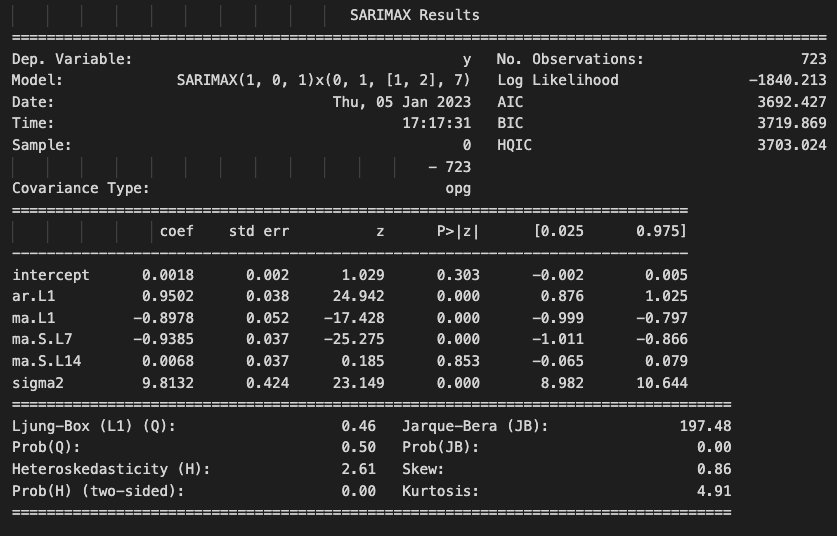

In [20]:
from IPython.display import Image
Image(filename='Results/SARIMA_7.png') 

L'AIC a baissé. C'est notre meilleur modèle. 
Par contre le paramètre moving average de niveau 2 n'est pas significatif.

Un paramètre de moyenne mobile plus grand intégrera plus d'erreurs précédentes, ce qui peut rendre le modèle plus stable et moins sensible au bruit. Cependant, un paramètre de moyenne mobile plus grand peut également rendre le modèle plus lent à s'adapter aux changements dans les données, ce qui peut entraîner une moins bonne performance lorsque les données changent rapidement.

D'un autre côté, un paramètre de moyenne mobile plus petit intégrera moins d'erreurs précédentes, ce qui peut rendre le modèle plus flexible et capable de s'adapter aux changements dans les données plus rapidement. Cependant, un paramètre de moyenne mobile plus petit peut également rendre le modèle plus sensible au bruit et moins stable.

# Visualisation

### Prediction de l'ensemble des points suivants

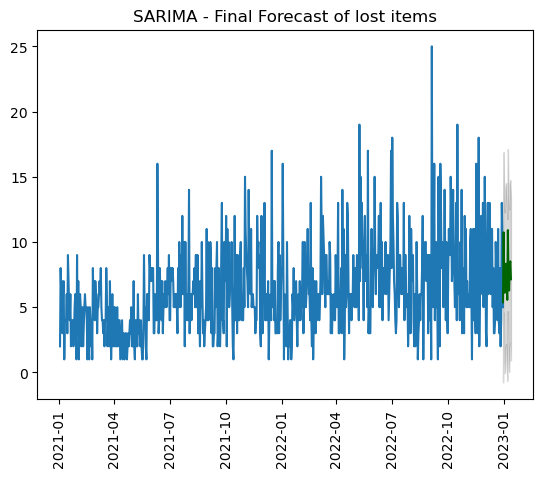

In [31]:
# Forecast
n_periods = 14 # du mardi au prochain dimanche
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot

plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of lost items")
plt.tick_params(axis='x',labelrotation=90)
plt.show()

### Prediction ARIMA

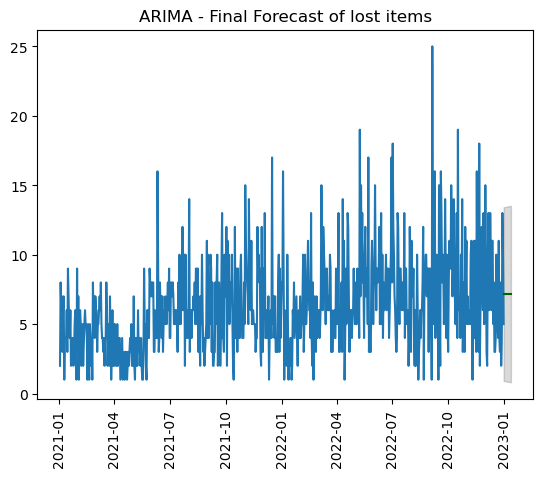

In [33]:
# Forecast
n_periods = 13 # du mardi au prochain dimanche
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot

plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of lost items")
plt.tick_params(axis='x',labelrotation=90)
plt.show()

In [3]:
print(type(range(0,8)))

<class 'range'>


In [4]:
Tile_matrice = [[1,2,3,4],
                [5,6,7,8]]
Tile_matrice[1][3]

8

In [6]:
import numpy as np
np.zeros(4)

0.0